In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

# SMU

Original filename: `Sep_1_2013_to_March_31_2020_SMU_geotrack_report_Redacted.pdf`

Described by US DOJ attorneys for ICE as follows:

> “The GEOtrack report that was provided to Plaintiffs runs from September 1, 2013 to March 31, 2020.  That report not only reports all placements into segregation, but it also tracks movement.  This means that if an individual is placed into one particular unit then simply moves to a different unit, it is tracked in that report (if an individual is moved from H unit cell 101 to H unit cell 102, it would reflect the move as a new placement on the report).”

GEO record of Segregation Management Unit placements by housing placement. Possibly generated by proprietary "GEOTrack" database?

In [7]:
smu = pd.read_csv('../input/smu.csv.gz', sep='|', quotechar='"', compression='gzip')

In [8]:
smu.head()

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour
0,GUATEMALA,H-NA-108,6/27/2013 1:31:00AM,4/9/2014 11:49:00PM,286,6/27/2013,1:31:00AM,4/9/2014,11:49:00PM
1,MEXICO,H-NA-205,8/5/2013 2:30:00PM,11/10/2014 6:34:00AM,462,8/5/2013,2:30:00PM,11/10/2014,6:34:00AM
2,MEXICO,H-NA-106,8/8/2013 10:08:00AM,9/6/2013 11:41:00AM,29,8/8/2013,10:08:00AM,9/6/2013,11:41:00AM
3,MARSHALL ISLANDS,H-NA-203,8/15/2013 11:17:00AM,9/13/2013 9:05:00AM,29,8/15/2013,11:17:00AM,9/13/2013,9:05:00AM
4,MEXICO,H-NA-209,8/15/2013 10:07:00PM,9/9/2013 12:00:00AM,25,8/15/2013,10:07:00PM,9/9/2013,12:00:00AM


In [9]:
len(smu)

3447

All dates convert successfully:

In [10]:
assert pd.to_datetime(smu['assigned_dt'], errors='coerce').isnull().sum() == 0
smu['assigned_dt'] = pd.to_datetime(smu['assigned_dt'])
assert pd.to_datetime(smu['removed_dt'], errors='coerce').isnull().sum() == 0
smu['removed_dt'] = pd.to_datetime(smu['removed_dt'])

Validating date fields: One field has a `removed_dt` value less than `assigned_dt`, but this is only a discrepancy in the hour values; can retain as 0 days, or drop, as we do here:

In [11]:
smu = smu.loc[smu['assigned_dt'] <= smu['removed_dt']]

Recalculating segregation placement length based on date only results in same value as `days_in_seg` field.


In [12]:
smu['days_calc'] = (pd.to_datetime(smu['removed_date']) - pd.to_datetime(smu['assigned_date'])) / np.timedelta64(1, 'D')
assert sum(smu['days_in_seg'] == smu['days_calc']) == len(smu)

In [13]:
smu['days_calc'].describe()

count    3446.000000
mean        9.939060
std        23.635741
min         0.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       488.000000
Name: days_calc, dtype: float64

Calculating hourly segregation placement length:

In [14]:
smu['hours_calc'] = (smu['removed_dt'] - smu['assigned_dt']) /  np.timedelta64(1, 'h')

In [15]:
smu['hours_calc'].describe()

count     3446.000000
mean       238.802679
std        566.660945
min          0.000000
25%         25.766667
50%         80.708333
75%        232.920833
max      11710.366667
Name: hours_calc, dtype: float64

In [16]:
smu['assigned_dt'].min()

Timestamp('2013-06-27 01:31:00')

In [17]:
smu['removed_dt'].max()

Timestamp('2020-03-31 12:00:00')

In [18]:
smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['hours_calc'].median()

assigned_dt
2013-01-01     76.216667
2014-01-01     69.333333
2015-01-01     77.666667
2016-01-01     74.083333
2017-01-01     91.700000
2018-01-01    110.400000
2019-01-01     81.891667
2020-01-01     48.800000
Freq: AS-JAN, Name: hours_calc, dtype: float64

In [19]:
smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['hours_calc'].mean()

assigned_dt
2013-01-01    258.733889
2014-01-01    187.874694
2015-01-01    226.096976
2016-01-01    239.043219
2017-01-01    298.401040
2018-01-01    265.279271
2019-01-01    225.643001
2020-01-01    171.884870
Freq: AS-JAN, Name: hours_calc, dtype: float64

In [20]:
assert sum(smu['citizenship'].isnull()) == 0

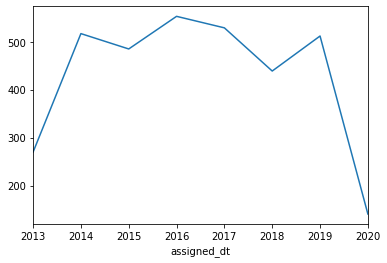

In [21]:
smu_annual = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['citizenship'].count()
smu_annual.plot()

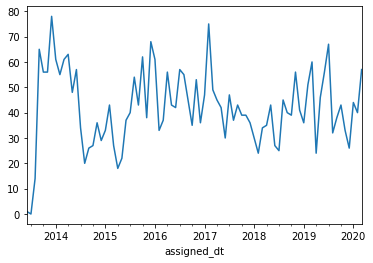

In [22]:
smu_monthly = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='M')])['citizenship'].count()
smu_monthly.plot()

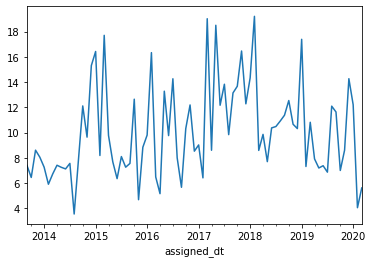

In [23]:
smu.set_index('assigned_dt').loc['2013-09-01':].groupby([pd.Grouper(freq='M')])['days_calc'].mean().plot()

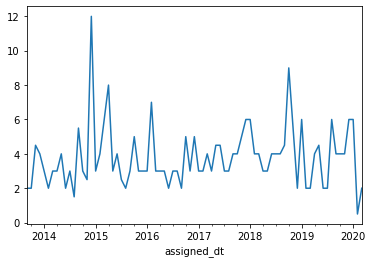

In [24]:
smu.set_index('assigned_dt').loc['2013-09-01':].groupby([pd.Grouper(freq='M')])['days_calc'].median().plot()

Stays over 14 days must be reported to ICE SRMS. Flagging long placements and calculating as percent of total placements. (Caveat: placements are by housing assignment, not cumulative stay length, so long stays are likely undercounted here.)

In [25]:
smu['long_stay'] = smu['days_calc'] > 14

In [26]:
long_g = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['long_stay'].sum()

In [27]:
count_g = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='AS')])['citizenship'].count()

Long stays are increasing over time both absolutely and as proportion of total placements:

In [28]:
(long_g / count_g * 100)

assigned_dt
2013-01-01    17.777778
2014-01-01    12.765957
2015-01-01    12.989691
2016-01-01    15.370705
2017-01-01    17.769376
2018-01-01    23.917995
2019-01-01    21.679688
2020-01-01    18.439716
Freq: AS-JAN, dtype: float64

In [29]:
long_g

assigned_dt
2013-01-01     48.0
2014-01-01     66.0
2015-01-01     63.0
2016-01-01     85.0
2017-01-01     94.0
2018-01-01    105.0
2019-01-01    111.0
2020-01-01     26.0
Freq: AS-JAN, Name: long_stay, dtype: float64

In [30]:
count_g

assigned_dt
2013-01-01    270
2014-01-01    517
2015-01-01    485
2016-01-01    553
2017-01-01    529
2018-01-01    439
2019-01-01    512
2020-01-01    141
Freq: AS-JAN, Name: citizenship, dtype: int64

In [31]:
len(smu.set_index('assigned_dt').loc[:'2014-06-30'])

615

In [32]:
smu.head()

,citizenship,housing,assigned_dt,removed_dt,days_in_seg,assigned_date,assigned_hour,removed_date,removed_hour,days_calc,hours_calc,long_stay
0,GUATEMALA,H-NA-108,2013-06-27 01:31:00,2014-04-09 23:49:00,286,6/27/2013,1:31:00AM,4/9/2014,11:49:00PM,286.0,6886.300000,True
1,MEXICO,H-NA-205,2013-08-05 14:30:00,2014-11-10 06:34:00,462,8/5/2013,2:30:00PM,11/10/2014,6:34:00AM,462.0,11080.066667,True
2,MEXICO,H-NA-106,2013-08-08 10:08:00,2013-09-06 11:41:00,29,8/8/2013,10:08:00AM,9/6/2013,11:41:00AM,29.0,697.550000,True
3,MARSHALL ISLANDS,H-NA-203,2013-08-15 11:17:00,2013-09-13 09:05:00,29,8/15/2013,11:17:00AM,9/13/2013,9:05:00AM,29.0,693.800000,True
4,MEXICO,H-NA-209,2013-08-15 22:07:00,2013-09-09 00:00:00,25,8/15/2013,10:07:00PM,9/9/2013,12:00:00AM,25.0,577.883333,True


In [33]:
len(smu['housing'].unique())

20

# RHU

Original file: `15_16_17_18_19_20_RHU_admission_Redacted.xlsx`

Log created and maintained by hand by GEO employee to track Restricted Housing Unit placements. Described by US DOJ attorneys for ICE as follows:

> “The [RHU] spreadsheet runs from January 2015 to May 28, 2020 and was created by and for a lieutenant within the facility once he took over the segregation lieutenant duties. The spreadsheet is updated once a detainee departs segregation. The subjects who are included on this list, therefore, are those who were placed into segregation and have already been released from segregation. It does not include those individuals who are currently in segregation.”

## Dates and total days calculation

Inspection of the original Excel file suggests that the `Total days` column values are incorrect throughout, based on a broken cell formula. For example, on the "2020" spreadsheet tab, the `Total days` column values are integers which only occasionally align with calculated placement length based on the `Date in` and `Date out` columns. However, additional spreadsheet rows at the bottom of the sheet not containing values in other fields contain an Excel formula ("=(D138-C138)+1") which should have been used to calculate these values. Comparing calculated stay lengths with reported `Total days` suggests that this formula was not updated consistently, causing fields to become misaligned. Additionally, the "2015" spreadsheet tab includes many `Total days` values equal to "1", suggesting that the formula was applied incorrectly or with missing data.

We can recalculate actual stay lengths based on the formula cited above (where stays of less than one day would be calculated as "1"); or with the formula used for the "SMU" records above (where stays of less than one day would be calculated as "0"), for more consistent comparison with other datasets.

The above issue raises the possibility that other fields in addition to `Total days` may be misaligned in the original dataset. One fact mitigating this possibility is that no `Date out` values predate associated `Date in` values. We can also look more closely at qualitative fields to make an educated guess as to the data quality. However, we do not intend to use this dataset for detailed qualitative analysis; of most interest are total segregation placements and segregation stay lengths.

In [ ]:
rhu = pd.read_csv('../input/rhu.csv.gz', sep='|', quotechar='"', compression='gzip')

In [ ]:
rhu.info()

In [ ]:
rhu.head()

In [ ]:
rhu['date_in'] = pd.to_datetime(rhu['date_in'])
rhu['date_out'] = pd.to_datetime(rhu['date_out'])

As noted above, no `date_out` values precede associated `date_in` values:

In [ ]:
assert sum(rhu['date_in'] > rhu['date_out']) == 0

Here we recalculate the `total days` field based on the formula in the original spreadsheet ("=(D138-C138)+1"):

In [ ]:
rhu['total_days_calc'] = (rhu['date_out'] - rhu['date_in']) / np.timedelta64(1, 'D') + 1

Less than 10% of `total_days` values match `total_days_calc`:

In [ ]:
sum(rhu['total_days_calc'] == rhu['total_days']) / len(rhu) * 100

Note that the summary statistics for the original field (`total_days`) are very similar to the recalculated field (`total_days_calc`), suggesting that most values are present in the dataset but misaligned:

In [ ]:
rhu['total_days'].describe()

In [ ]:
rhu['total_days_calc'].describe()

The symmetrical distribution of values when analyzing the difference between the fields also suggests that values are largely misaligned rather than miscalculated:

In [ ]:
# why so symmetrical?
(rhu['total_days_calc'] - (rhu['total_days'])).describe()

Therefore, we will conclude that it is correct to recalculate the `total_days` field here. We will follow the formula used for other datasets in this repository, where stays of less than one day would be calculated as "0".

In [ ]:
rhu['total_days'] = (rhu['date_out'] - rhu['date_in']) / np.timedelta64(1, 'D')

In [ ]:
rhu = rhu.drop('total_days_calc', axis=1)

In [ ]:
rhu['total_days'].describe()

In [ ]:
assert sum(pd.isnull(rhu['name'])) == 0

In [ ]:
rhu_annual = rhu.set_index('date_in').groupby(pd.Grouper(freq='AS'))['name'].count()

In [ ]:
rhu_monthly = rhu.set_index('date_in').groupby(pd.Grouper(freq='M'))['name'].count()

In [ ]:
rhu.set_index('date_in').groupby(pd.Grouper(freq='AS'))['total_days'].mean()

# RHU/SMU comparison

In [ ]:
data = pd.concat([rhu_annual, smu_annual], axis=1)

In [ ]:
data.columns = ['RHU', 'SMU']

In [ ]:
data.plot(kind='bar')

In [ ]:
data

In [ ]:
data = pd.concat([rhu_monthly, smu_monthly], axis=1)
data.columns = ['RHU', 'SMU']
data.plot()

# SRMS data

In [34]:
srms_1 = pd.read_csv('../input/srms-1.csv.gz', sep='|', compression='gzip')
srms_2 = pd.read_csv('../input/srms-2.csv.gz', sep='|', compression='gzip')

In [35]:
srms_1.columns

Index(['tracking_number', 'gender', 'country_of_citizenship', 'facility_aor',
       'facility', 'facility:detloc', 'report_type', 'placement_date',
       'placement_reason', 'release_date', 'length_of_stay',
       'disciplinary_infraction', 'sanction_length', 'detailed_reason',
       'attorney_of_record', 'attorney_notification', 'detainee_request',
       'compliance_with_detention_standards', 'mental_illness',
       'serious_medical_illness', 'serious_disability', 'ever_smi',
       'fo_recommendation', 'additional_comments_export',
       'non_compliance_detail', 'special_criteria', 'id', 'current_review',
       'created', 'lgbti', 'item_type', 'placement_reason_type', 'detloc'],
      dtype='object')

In [36]:
srms_1['placement_date'] = pd.to_datetime(srms_1['placement_date'])
srms_1['release_date'] = pd.to_datetime(srms_1['release_date'])
srms_2['placement_date'] = pd.to_datetime(srms_2['placement_date'])
srms_2['release_date'] = pd.to_datetime(srms_2['release_date'])

In [37]:
srms_1['days_calc'] = (srms_1['release_date'] - srms_1['placement_date']) / np.timedelta64(1, 'D')
srms_2['days_calc'] = (srms_2['release_date'] - srms_2['placement_date']) / np.timedelta64(1, 'D')

There are no SRMS records with placement and release on same day; this suggests comparison with first-day-inclusive calculation for stay length for SMU/RHU records.

In [39]:
srms_1['days_calc'].describe()

count    357.000000
mean      59.605042
std       88.263162
min        1.000000
25%       19.000000
50%       30.000000
75%       62.000000
max      781.000000
Name: days_calc, dtype: float64

In [41]:
srms_2['days_calc'].describe()

count    459.000000
mean      59.052288
std       76.574175
min        1.000000
25%       20.000000
50%       31.000000
75%       66.000000
max      691.000000
Name: days_calc, dtype: float64

In [38]:
srms_1_annual = srms_1.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['tracking_number'].count()
srms_2_annual = srms_2.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['tracking_number'].count()
srms_1_monthly = srms_1.set_index('placement_date').groupby(pd.Grouper(freq='M'))['tracking_number'].count()
srms_2_monthly = srms_2.set_index('placement_date').groupby(pd.Grouper(freq='M'))['tracking_number'].count()

## Comparison of placement counts

In [ ]:
data = pd.concat([rhu_annual, smu_annual, srms_1_annual, srms_2_annual], axis=1)

In [ ]:
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']

In [ ]:
data.plot(kind='bar')

In [ ]:
data

In [ ]:
data = pd.concat([rhu_monthly, smu_monthly, srms_1_monthly, srms_2_monthly], axis=1)
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']
data.plot()

## Comparison avg. placement length over time

In [ ]:
smu_mean = smu.set_index('assigned_dt').groupby([pd.Grouper(freq='Q')])['days_calc'].mean()

In [ ]:
rhu_mean = rhu.set_index('date_in').groupby([pd.Grouper(freq='Q')])['total_days'].mean()

In [ ]:
srms_1_mean = srms_1.set_index('placement_date').groupby([pd.Grouper(freq='Q')])['days_calc'].mean()

In [ ]:
srms_2_mean = srms_2.set_index('placement_date').groupby([pd.Grouper(freq='Q')])['days_calc'].mean()

In [ ]:
data = pd.concat([rhu_mean, smu_mean, srms_1_mean, srms_2_mean], axis=1)
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']
data.plot()

In [ ]:
data

## Comparing "long stays"

Solitary placements longer than 14 days should be reported to SRMS. Yet GEO records consistently report more long stays than long stays reflected in SRMS

In [ ]:
rhu['long_stay'] = rhu['total_days'] > 14

In [ ]:
srms_1['long_stay'] = srms_1['days_calc'] > 14
srms_2['long_stay'] = srms_2['days_calc'] > 14

In [ ]:
rhu_long = rhu.set_index('date_in').groupby(pd.Grouper(freq='AS'))['long_stay'].sum()

In [ ]:
smu_long = smu.set_index('assigned_dt').groupby(pd.Grouper(freq='AS'))['long_stay'].sum()

In [ ]:
srms_1_long = srms_1.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['long_stay'].sum()
srms_2_long = srms_2.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['long_stay'].sum()

In [ ]:
data = pd.concat([rhu_long, smu_long, srms_1_long, srms_2_long], axis=1)
data.columns = ['RHU', 'SMU', 'SRMS 1', 'SRMS 2']
data.plot(kind='bar')

In [ ]:
data

### Comparison of only long RHU/SMU stays versus all SRMS stays

In [ ]:
data = pd.concat([rhu_long, smu_long, srms_1_annual, srms_2_annual], axis=1)
data.columns = ['RHU long', 'SMU long', 'SRMS 1 all', 'SRMS 2 all']
data.plot(kind='bar')

In [ ]:
data

In [ ]:
rhu['long_stay'].sum() / len(rhu)

In [ ]:
smu['long_stay'].sum() / len(smu)

In [ ]:
srms_1['long_stay'].sum() / len(srms_1)

In [ ]:
srms_2['long_stay'].sum() / len(srms_2)

In [ ]:
len(rhu)

In [ ]:
len(srms_2)

# Join datasets

In [ ]:
smu.columns

In [ ]:
smu_ex = smu[['assigned_date', 'removed_date']].copy()
smu_ex = smu_ex.rename({'assigned_date': 'placement_date', 'removed_date': 'release_date'}, axis=1) 
smu_ex.loc[:,'placement_date'] = pd.to_datetime(smu_ex['placement_date'])
smu_ex.loc[:,'release_date'] = pd.to_datetime(smu_ex['release_date'])
smu_ex['dataset'] = 'SMU'
# First day inclusive:
smu_ex['days_calc'] = (smu_ex['release_date'] - smu_ex['placement_date']) / np.timedelta64(1, 'D') + 1

In [ ]:
rhu.columns

In [ ]:
rhu_ex = rhu[['date_in', 'date_out']].copy()
rhu_ex = rhu_ex.rename({'date_in': 'placement_date', 'date_out': 'release_date'}, axis=1)
rhu_ex['dataset'] = 'RHU'
# First day inclusive:
rhu_ex['days_calc'] = (rhu_ex['release_date'] - rhu_ex['placement_date']) / np.timedelta64(1, 'D') + 1

In [ ]:
srms_1.columns

In [ ]:
srms_1_ex = srms_1[['placement_date', 'release_date']].copy()
srms_1_ex['dataset'] = 'SRMS 1'
# SRMS datasets are already first day inclusive:
srms_1_ex['days_calc'] = (srms_1_ex['release_date'] - srms_1_ex['placement_date']) / np.timedelta64(1, 'D')

srms_2_ex = srms_2[['placement_date', 'release_date']].copy()
srms_2_ex['dataset'] = 'SRMS 2'
# SRMS datasets are already first day inclusive:
srms_2_ex['days_calc'] = (srms_2_ex['release_date'] - srms_2_ex['placement_date']) / np.timedelta64(1, 'D')

In [ ]:
df = pd.concat([smu_ex, rhu_ex, srms_1_ex, srms_2_ex], axis=0)

In [ ]:
df = df.dropna()

In [ ]:
# df.loc[:,'placement_date'] = pd.to_datetime(df['placement_date'])
# df.loc[:,'release_date'] = pd.to_datetime(df['release_date'])

In [ ]:
# df['days_calc'] = (df['release_date'] - df['placement_date']) / np.timedelta64(1, 'D')

In [ ]:
df['long_stay'] = df['days_calc'] > 14

In [ ]:
table = pd.DataFrame()

In [ ]:
table['total'] = df.groupby(['dataset'])['placement_date'].count()
table['min_date'] = df.groupby(['dataset'])['placement_date'].min()
table['max_date'] = df.groupby(['dataset'])['placement_date'].max()
table['avg_length'] = df.groupby(['dataset'])['days_calc'].mean()
table['med_length'] = df.groupby(['dataset'])['days_calc'].median()
table['min_length'] = df.groupby(['dataset'])['days_calc'].min()
table['max_length'] = df.groupby(['dataset'])['days_calc'].max()
# table['total_days'] = df.groupby(['dataset'])['days_calc'].sum()
table['total_long'] = df.groupby(['dataset'])['long_stay'].sum()
# table['pct_long'] = (df.groupby(['dataset'])['long_stay'].sum()) / (df.groupby(['dataset'])['placement_date'].count())

In [ ]:
table

In [ ]:
table.to_csv('../output/dataset_description.csv')

In [ ]:
d = df[df['dataset'] != 'SRMS 1']
d = d[d['long_stay'] == True]
d = d.set_index('placement_date').loc['2015-01-03': '2020-03-16']

In [ ]:
g = d.groupby([pd.Grouper(freq='AS'), 'dataset'])['long_stay'].sum().unstack()

In [ ]:
g.plot(kind='bar')

In [ ]:
g

In [ ]:
d = df[df['dataset'] != 'SRMS 1']
d = d[d['long_stay'] == True]
d = d.set_index('placement_date').loc['2015-01-03':'2020-03-16']

In [ ]:
g = d.groupby([pd.Grouper(freq='AS'), 'dataset'])['days_calc'].sum().unstack()

In [ ]:
g.plot(kind='bar')

In [ ]:
g.sum()

In [ ]:
df[df['dataset'] == 'SRMS 2'].set_index('placement_date').loc['2015-01-03':'2020-03-16']['days_calc'].sum()

In [ ]:
rhu['placement_reason'].str.upper().value_counts()

In [ ]:
rhu['placement_reason'] = rhu['placement_reason'].str.strip().str.upper()

In [ ]:
placement_reasons = set(rhu['placement_reason'])

In [ ]:
# with open('../hand/placement-reasons.yaml', 'w') as outfile:
#         yaml.dump(dict(zip(placement_reasons, placement_reasons)),
#                   outfile,
#                   default_flow_style=False,
#                   allow_unicode=True)

In [ ]:
rhu['initial_placement'] = rhu['initial_placement'].str.strip().str.upper()

In [ ]:
rhu['disc_seg'] = rhu['disc_seg'].str.strip().str.upper()

In [ ]:
initial_placement = {'PENDING HEARING': 'PENDING HEARING',
                    'SECURITY RISK': 'SECURITY RISK',
                    'MEDICAL': 'MEDICAL',
                    'PROTECTIVE CUSTODY': 'PROTECTIVE CUSTODY',
                    'DISCIPLINARY': 'DISCIPLINARY',
                    'PENDING TRANSFER': 'PENDING TRANSFER',
                    'DISCIPLINARY DETENTION': 'DISCIPLINARY',
                    'MEDICAL / PC': 'MEDICAL',
                    'MEDICAL / SECURITY RISK': 'MEDICAL',
                    'DISCIPLINE': 'DISCIPLINARY',
                    'SECURING RISK': 'SECURITY RISK',
                    'PENDING HEAR': 'PENDING HEARING'}

In [ ]:
rhu['initial_placement'] = rhu['initial_placement'].replace(initial_placement)

In [ ]:
place_g = rhu.set_index('date_in').groupby([pd.Grouper(freq='AS'), 'initial_placement'])['name'].count()

In [ ]:
count_g = rhu.set_index('date_in').groupby([pd.Grouper(freq='AS')])['name'].count()

In [ ]:
(place_g / count_g) * 100

In [ ]:
place_g.unstack().plot(kind='bar')

In [ ]:
seg_g = rhu.set_index('date_in').groupby([pd.Grouper(freq='AS'), 'disc_seg'])['name'].count()

In [ ]:
(((seg_g / count_g) * 100)).unstack().plot(kind='bar')

In [ ]:
rhu.groupby(['disc_seg', 'initial_placement'])['name'].count()

In [ ]:
rhu.set_index('date_in').groupby(pd.Grouper(freq='AS'))['total_days'].median()

In [ ]:
rhu.set_index('date_in').groupby(pd.Grouper(freq='AS'))['total_days'].mean()

In [ ]:
rhu['long_stay'] = rhu['total_days'] > 14

In [ ]:
len(rhu)

In [ ]:
rhu['date_in'].min()

In [ ]:
rhu['date_in'].max()

In [ ]:
rhu['date_out'].min()

In [ ]:
rhu['date_out'].max()

In [ ]:
long_g = rhu.set_index('date_in').groupby([pd.Grouper(freq='AS')])['long_stay'].sum()

count_g = rhu.set_index('date_in').groupby([pd.Grouper(freq='AS')])['name'].count()

(long_g / count_g * 100)

In [ ]:
long_g

In [ ]:
len(rhu.set_index('date_in').loc['2015-01-01':'2019-12-31'])

In [ ]:
len(smu.set_index('assigned_dt').loc['2015-01-01':'2019-12-31'])

In [ ]:
rhu.set_index('date_in').groupby(pd.Grouper(freq='AS-JAN'))['Name'].count()

In [ ]:
smu.set_index('assigned_dt').groupby(pd.Grouper(freq='AS-JAN'))['Citizenship'].count()

In [ ]:
# Cases classified as hunger strikes internally but not reported to ICE as hunger strikes?
# No suicide watch placements?
# Significant incident reports?

In [ ]:
strike_demo = ['HUNGER STRIKE',
               'GROUP DEMONSTRATION',
               'MEAL MONITORING',
               'FEARS GEN POP / HUNGER STRIKE',
               'INCITING GROUP DEMONSTRATION',
               'INCITING GROUP DEMONSTATION'
              ]

In [ ]:
suicide = ['ENDANGERING SELF / OTHERS',
           'FEARS OTHERS / SELF IN GP',
           'FEARS SELF IN GEN POP',
           'THREAT TO OTHERS / SELF',
           'THREAT TO SELF / OTHERS',
           'THREAT TO SELF/OTHERS',
           'CONSTANT WATCH'
          ]

In [ ]:
rhu.loc[rhu['placement_reason'].isin(strike_demo), 'total_days'].describe()

In [ ]:
rhu.loc[rhu['placement_reason'].isin(suicide), 'total_days'].describe()

In [ ]:
rhu.loc[rhu['placement_reason'] == 'TRANSGENDER PENDING HOUSING']

In [ ]:
redacted = '(B)(6), (B)(7)(C), (B)(7)(E)'
rhu.loc[rhu['placement_reason'] == redacted, 'total_days'].describe()

In [ ]:
# hunger strike or similar placements which should be reported to SRMS
# note total_days calc discrepancies
rhu.loc[(rhu['placement_reason'].isin(strike_demo)) & (rhu['total_days'] > 14), :]

In [ ]:
rhu['total_days'] > 14

In [ ]:
srms = pd.read_csv('../input/uwchr-2.csv.gz', sep='|', quotechar='"', compression='gzip')

In [ ]:
srms.head()

In [ ]:
srms.info()

In [ ]:
srms['placement_date'] = pd.to_datetime(srms['placement_date'])
srms['release_date'] = pd.to_datetime(srms['release_date'])

In [ ]:
srms.set_index('placement_date').groupby(pd.Grouper(freq='AS'))['tracking_number'].count()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

x=rhu.loc[:, 'date_in'].astype(int)
y=rhu.loc[:,'total_days']

plt.scatter(x, y, alpha=1, marker='x')

x=rhu.loc[:, 'date_in'].astype(int)
y=rhu.loc[:,'total_days_calc']
plt.scatter(x, y, alpha=.5, marker='+')

plt.yscale('log')
plt.ylim(.6, 1000)

xticks = ax.get_xticks()
xticks_dates = [str(f'{pd.to_datetime(x).year}-Q{pd.to_datetime(x).quarter}') for x in xticks]
ax.set_xticklabels(xticks_dates,  rotation=45)
plt.show()
plt.close(fig=fig)
del fig, ax

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

# x=rhu.loc[:, 'date_in'].astype(int)
# y=rhu.loc[:,'total_days']

# plt.scatter(x, y, alpha=1, marker='x')

x=rhu.loc[:, 'date_in'].astype(int)
y=rhu.loc[:,'total_days_calc']
plt.scatter(x, y, alpha=1, marker='+')

# plt.yscale('log')
# plt.ylim(.6, 1000)

xticks = ax.get_xticks()
xticks_dates = [str(f'{pd.to_datetime(x).year}-Q{pd.to_datetime(x).quarter}') for x in xticks]
ax.set_xticklabels(xticks_dates,  rotation=45)
plt.show()
plt.close(fig=fig)
del fig, ax

In [ ]:
rhu.columns

In [ ]:
rhu.set_index('date_in').groupby([pd.Grouper(freq='Q')])['total_days'].median().plot()
rhu.set_index('date_in').groupby([pd.Grouper(freq='Q')])['total_days_calc'].median().plot()

In [ ]:
smu.columns

In [ ]:
min_date = smu['assigned_dt'].min().date()
max_date = smu['removed_dt'].max().date()
timeline = pd.date_range(min_date, max_date, freq='D')
years = timeline.year.unique()

counts = pd.Series(index=timeline)
for day in timeline:
    in_range = smu[(smu['assigned_dt'] <= day) & (smu['removed_dt'] >= day)]
    counts[day] = len(in_range)

In [ ]:
fig, ax = plt.subplots()
fig.figsize=(10,8)

ax = counts.plot()
ax = counts.groupby(pd.Grouper(freq='M')).mean().plot(color='r')
ax.set_facecolor('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(color='#FFFFFF')
plt.title('NWDC Daily SMU Population', fontsize=16)
plt.xlabel('Calendar year', fontsize=12)
plt.ylabel('Total solitary pop.', fontsize=12)
leg = ax.legend(('Population', 'Monthly Avg.'), loc='upper right', bbox_to_anchor=(1.35, 1))
plt.show()
# fig.savefig('samplefigure', bbox_inches='tight')

In [ ]:
counts.groupby(pd.Grouper(freq='M')).mean().plot()